<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn import linear_model
import lightgbm as lgb
import lightgbm as lgm
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor# для работы с моделью DummyRegressor
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [2]:
print(df.index.is_monotonic)

True


In [3]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

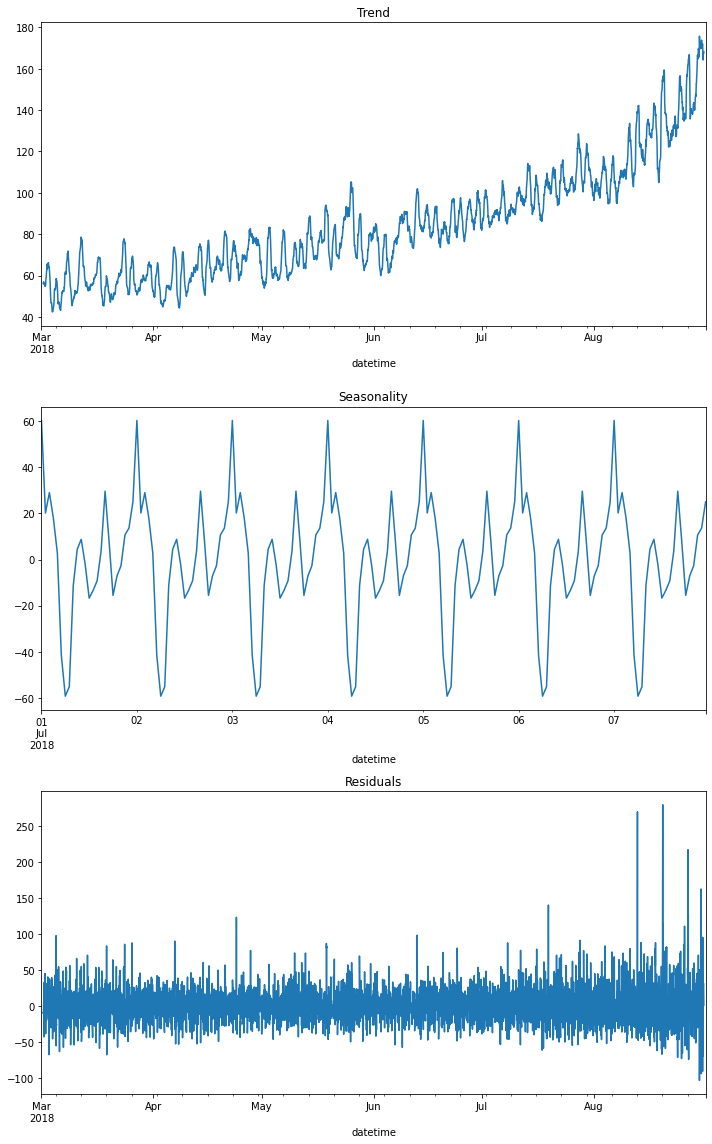

In [5]:
decompose = seasonal_decompose(df)

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decompose.seasonal['2018-07-01':'2018-07-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

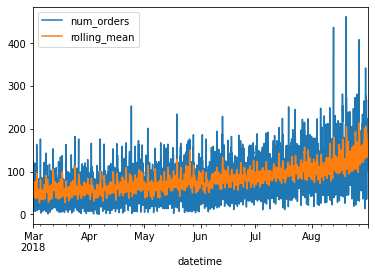

In [6]:
df['rolling_mean'] = df.rolling(10).mean()
df.plot()

Из декомпозиции можно отметить, что тренд указывает на увеличение заказов. Сезоность указывает на высокий спрос на такси в ночное время, потому что в это время не работает общественный транспорт.

Можно сказать, что стохастический процесс нестационарный

## Обучение

In [7]:
def prep_data(df, max_lag, rolling_mean_size):
    df_new = pd.DataFrame(df.copy())
    df_new['year'] = df_new.index.year
    df_new['month'] = df_new.index.month
    df_new['day'] = df_new.index.day
    df_new['dayofweek'] = df_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_new['lag_{}'.format(lag)] = df_new['num_orders'].shift(lag)

    df_new['rolling_mean'] = df_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    #Разобьем датасет на обучающую и тестовую выборки. Тестовую выборку делаем размером 10% от исходных данных
    train, test = train_test_split(df_new, shuffle=False, test_size= 0.1)
    train = train.dropna()
    
    #Выделим признаки и целевой признак
    train_target = train['num_orders']
    train_features = train.drop('num_orders', axis=1)
    test_target = test['num_orders']
    test_features = test.drop('num_orders', axis=1)
    
    return train_features, test_features, train_target, test_target

#make_features(df, 24, 10)
#df.shape

In [8]:
#print(df.info())
#df.head(10)

In [9]:
#df = df.dropna()

In [10]:
#df.shape

In [11]:
#df.head(10)

Применим функцию make_features на подготовленный датасет. Разделим датасет (тестовая выборка 10%), попробуем разные модели:

In [12]:
#train_val, test = train_test_split(df, shuffle=False, test_size=0.1)
#train, valid = train_test_split(train_val, shuffle=False, test_size=0.25)
 #Разобьем датасет на обучающую и тестовую выборки. Тестовую выборку делаем размером 10% от исходных данных
#train, test = train_test_split(df, shuffle=False, test_size=0.1)
#train = train.dropna()

#Выделим признаки и целевой признак
#train_features = train.drop('num_orders', axis = 1)
#train_target = train['num_orders']

#valid_features = valid.drop('num_orders', axis =1)
#valid_target = valid['num_orders']

#test_features = test.drop('num_orders', axis = 1)
#test_target = test['num_orders']

In [13]:
#print(train.shape, valid.shape, test.shape)

Проведем подбор параметров на модели light gbm:

In [14]:
%%time
#исходные данные
train_features, test_features, train_target, test_target = prep_data(df, max_lag =24, rolling_mean_size=10)

estim_new = lgb.LGBMRegressor(random_state=12345)


param_grid = {
    'max_depth': range (1,5,1),
    #'num_leaves': [5, 10, 15],
    'learning_rate': [i for i in np.geomspace(0.1,1.0,5)],
    'n_estimators': range (100,1000,100)
}

cv = TimeSeriesSplit(n_splits=3)
gbm = GridSearchCV(estim_new, param_grid, cv=cv, scoring='neg_root_mean_squared_error',n_jobs=-1)

gbm.fit(train_features, train_target)

print('Best parameters is:', gbm.best_params_)
print('Best score is:', -gbm.best_score_)

Best parameters is: {'learning_rate': 0.1778279410038923, 'max_depth': 3, 'n_estimators': 100}
Best score is: 26.996388445940415
CPU times: user 14min 49s, sys: 8.43 s, total: 14min 57s
Wall time: 15min 4s


In [15]:
#gbm_best_param = gbm.best_params_
#light_gbm = lgb.LGBMRegressor(**gbm_best_param, random_state = 12345)
#light_gbm.fit(train_features, train_target)
#predicted_light_valid = light_gbm.predict(valid_features)
#rmse_light_gbm = mean_squared_error(valid_target, predicted_light_valid)**0.5
#rmse_light_gbm

И попробуем модель CatBoost:

In [16]:
%%time
model_cat = CatBoostRegressor(depth = 5, n_estimators = 200, learning_rate = 0.1, loss_function = 'MAE', eval_metric = 'RMSE')
model_cat.fit(train_features, train_target, verbose=10)
predicted_cat = model_cat.predict(test_features)
rmse_cat = (mean_squared_error(test_target, predicted_cat))**0.5
rmse_cat

0:	learn: 37.1853353	total: 51.6ms	remaining: 10.3s
10:	learn: 28.9905041	total: 87ms	remaining: 1.49s
20:	learn: 26.4581526	total: 122ms	remaining: 1.04s
30:	learn: 25.3862937	total: 158ms	remaining: 863ms
40:	learn: 24.6064995	total: 193ms	remaining: 748ms
50:	learn: 24.0190422	total: 228ms	remaining: 666ms
60:	learn: 23.5761233	total: 268ms	remaining: 612ms
70:	learn: 23.2018044	total: 307ms	remaining: 558ms
80:	learn: 22.9003120	total: 343ms	remaining: 504ms
90:	learn: 22.5653618	total: 377ms	remaining: 451ms
100:	learn: 22.2830319	total: 411ms	remaining: 403ms
110:	learn: 21.9489852	total: 447ms	remaining: 358ms
120:	learn: 21.7291023	total: 480ms	remaining: 314ms
130:	learn: 21.5227658	total: 514ms	remaining: 271ms
140:	learn: 21.2869088	total: 547ms	remaining: 229ms
150:	learn: 21.1149425	total: 581ms	remaining: 189ms
160:	learn: 20.8715270	total: 615ms	remaining: 149ms
170:	learn: 20.6959614	total: 650ms	remaining: 110ms
180:	learn: 20.5470645	total: 684ms	remaining: 71.8ms
190

46.993554341549725

In [17]:
test_features.shape, test_target.shape

((442, 29), (442,))

## Тестирование

In [18]:
gbm_best_param = gbm.best_params_
light_gbm = lgb.LGBMRegressor(**gbm_best_param, random_state = 12345)
light_gbm.fit(train_features, train_target)
predicted_light_test = light_gbm.predict(test_features)
rmse_light_gbm_test = mean_squared_error(test_target, predicted_light_test)**0.5
rmse_light_gbm_test

42.036557793521766

In [19]:
#predicted_cat_test = model_cat.predict(test_features)
#rmse_cat_test = mean_squared_error(test_target, predicted_cat_test)**0.5
#rmse_cat_test

Проверка модели на адекватность по среднему значению:

In [20]:
#predicted_mean = np.ones(test.shape[0])*train['num_orders'].mean()
#rmse_mean = mean_squared_error(test_target, predicted_mean)**0.5
#print("Оценка RMSE по среднему значению :", rmse_mean)

In [21]:
from sklearn.dummy import DummyRegressor# для работы с моделью DummyRegressor
train_features, test_features, train_target, test_target = prep_data(df, max_lag=24, rolling_mean_size=10)
        
model_const = DummyRegressor()
model_const.fit(train_features, train_target)
predicted = model_const.predict(train_features)
RMSE_const = round(mean_squared_error(train_target, predicted)**0.5)

print('DummyRegressor:RMSE -',RMSE_const)

DummyRegressor:RMSE - 39


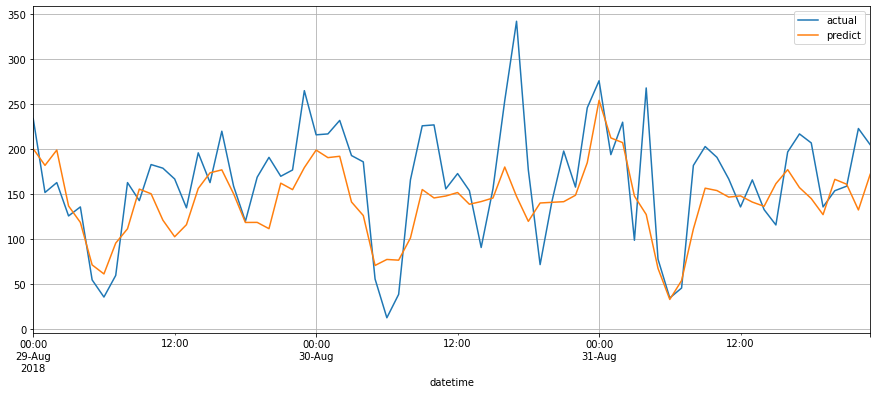

In [22]:
predict_series = pd.Series(predicted_light_test, index=test_target.index)
plt.figure(figsize=(15, 6))
test_target['2018-08-29':'2018-08-31'].plot(legend=True, label='actual')

predict_series['2018-08-29':'2018-08-31'].plot(legend=True, label='predict')
plt.grid(True)
plt.show()

В результате лучшая модель это LightGBM, значение метрики rmse на лучшей модели на тестовой выборке не превышает указанного в задании 48.